In [1]:
from Data.LatentDataset import LatentFMRIDataset
import matplotlib.pylab as pl
import ot.plot
import ot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.mixture import GaussianMixture
import torch
from tqdm import tqdm

In [2]:
nyu_dataset_directory = '/Users/balazsmorvay/PycharmProjects/VAE/Assets/NYU_all'
um1_dataset_directory = '/Users/balazsmorvay/PycharmProjects/VAE/Assets/UM_1_all'
merged_set_directory = '/Users/balazsmorvay/PycharmProjects/VAE/Assets/NYU_UM1_merged'

In [3]:
nyu_data = LatentFMRIDataset(data_dir=nyu_dataset_directory).get_all_items()
um1_data = LatentFMRIDataset(data_dir=um1_dataset_directory).get_all_items()

In [4]:
X_nyu = nyu_data['X']
y_nyu = nyu_data['y']
X_um1 = um1_data['X']
y_um1 = um1_data['y']
X_nyu, y_nyu = shuffle(X_nyu, y_nyu, random_state=41)
X_um1, y_um1 = shuffle(X_um1, y_um1, random_state=41)

X_nyu = X_nyu.reshape((X_nyu.shape[0], -1))
X_um1 = X_um1.reshape((X_um1.shape[0], -1))

X_nyu.shape, y_nyu.shape, X_um1.shape, y_um1.shape

((29575, 1152), (29575,), (23600, 1152), (23600,))

Train on X_nyu, 80% of X_um1
Test on 20% X_um1

In [5]:
# Train test split of UM1
X_um1_train = X_um1[:int(0.8*X_um1.shape[0])]
X_um1_test = X_um1[int(0.8*X_um1.shape[0]):]
y_um1_train = y_um1[:int(0.8*y_um1.shape[0])]
y_um1_test = y_um1[int(0.8*y_um1.shape[0]):]
X_um1_train.shape, y_um1_train.shape, X_um1_test.shape, y_um1_test.shape

((18880, 1152), (18880,), (4720, 1152), (4720,))

# Fit Gaussians to the NYU features

In [6]:
# Approximate the feature distributions with a superposition of 2 gaussians
gm = GaussianMixture(n_components=2, covariance_type='diag', random_state=41).fit(X_nyu)
gm.means_.shape

(2, 1152)

In [7]:
means = gm.means_.T
variances = gm.covariances_.T

[]

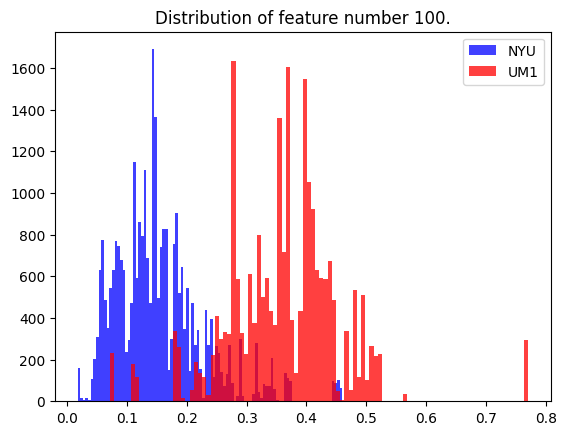

In [15]:
index_to_plot = 100

plt.hist(x=(X_nyu[:, index_to_plot]), color=['blue'], alpha=0.75, bins=100, label="NYU")
plt.hist(x=(X_um1[:, index_to_plot]), color=['red'], alpha=0.75, bins=100, label="UM1")
plt.title(f"Distribution of feature number {index_to_plot}.")
plt.legend(loc='upper right')
plt.plot()

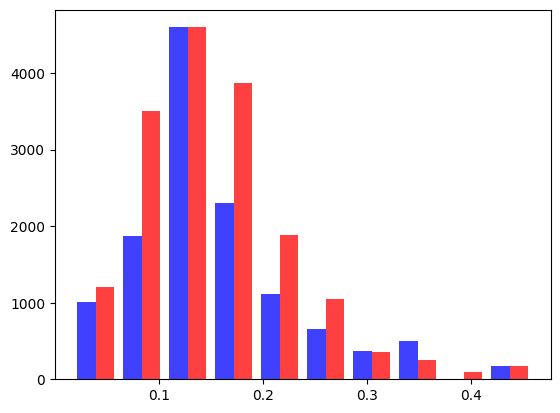

In [9]:
from scipy.stats import norm

index_to_plot = 100

plt.hist(x=(X_nyu[y_nyu == 1, index_to_plot], X_nyu[y_nyu == 2, index_to_plot]), color=['blue', 'red'], alpha=0.75)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, means[index_to_plot, 0], np.sqrt(variances[index_to_plot, 0]))
p = p  * 500
p2 = norm.pdf(x, means[index_to_plot, 1], np.sqrt(variances[index_to_plot, 1]))
p2 = p2 * 500
p_superposition = p + p2
plt.plot(x, p, 'r', linewidth=2)
plt.plot(x, p2, 'b', linewidth=2)
plt.plot(x, p_superposition, 'g', linewidth=2)
plt.show()

# Fit Gaussians to the UM1 features

In [9]:
# Approximate the feature distributions with a superposition of 2 gaussians
gm_um1 = GaussianMixture(n_components=2, covariance_type='diag', random_state=41).fit(X_um1_train)
gm_um1.means_.shape, gm_um1.covariances_.shape

((2, 1152), (2, 1152))

In [10]:
means_um1 = gm_um1.means_.T
variances_um1 = gm_um1.covariances_.T

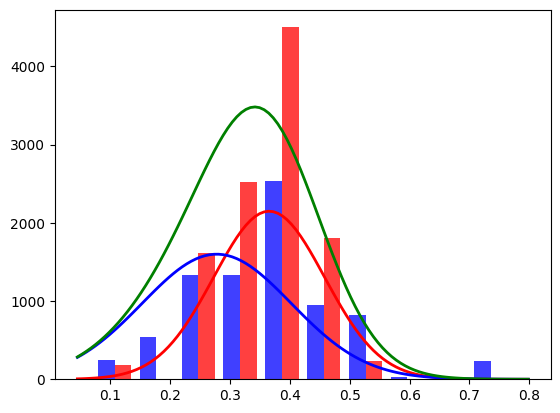

In [11]:
from scipy.stats import norm

index_to_plot = 100

plt.hist(x=(X_um1_train[y_um1_train == 1, index_to_plot], X_um1_train[y_um1_train == 2, index_to_plot]), color=['blue', 'red'], alpha=0.75)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, means_um1[index_to_plot, 0], np.sqrt(variances_um1[index_to_plot, 0]))
p = p  * 500
p2 = norm.pdf(x, means_um1[index_to_plot, 1], np.sqrt(variances_um1[index_to_plot, 1]))
p2 = p2 * 500
p_superposition = p + p2
plt.plot(x, p, 'r', linewidth=2)
plt.plot(x, p2, 'b', linewidth=2)
plt.plot(x, p_superposition, 'g', linewidth=2)
plt.show()

# Compute the optimal transport plan: UM1 -> NYU (train)

100%|██████████| 1152/1152 [00:01<00:00, 719.01it/s]


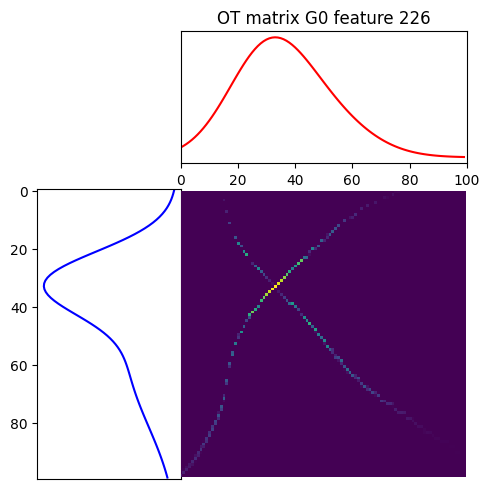

In [12]:
n_bins = 100
index_to_plot = 226
USE_SINKHORN = False
feature_ranges = np.zeros(shape=(2, 1152, 2)) # (nyu, um1) x features x (min, max)

if USE_SINKHORN:
    S_plans = np.zeros(shape=(1152, 100, 100))
else:
    EMD_plans = np.zeros(shape=(1152, 100, 100))

for feature_index in tqdm(range(1152)):
    xmin, xmax = np.min(X_nyu[:, feature_index]), np.max(X_nyu[:, feature_index])
    feature_ranges[0, feature_index, 0] = xmin
    feature_ranges[0, feature_index, 1] = xmax
    x = np.linspace(xmin, xmax, n_bins)
    p_nyu = norm.pdf(x, means[feature_index, 0], np.sqrt(variances[feature_index, 0]))
    p2_nyu = norm.pdf(x, means[feature_index, 1], np.sqrt(variances[feature_index, 1]))
    p_superposition_nyu = p_nyu + p2_nyu
    
    xmin, xmax = np.min(X_um1[:, feature_index]), np.max(X_um1[:, feature_index])
    x = np.linspace(xmin, xmax, n_bins)
    feature_ranges[1, feature_index, 0] = xmin
    feature_ranges[1, feature_index, 1] = xmax
    p_um1 = norm.pdf(x, means_um1[feature_index, 0], np.sqrt(variances_um1[feature_index, 0]))
    p2_um1 = norm.pdf(x, means_um1[feature_index, 1], np.sqrt(variances_um1[feature_index, 1]))
    p_superposition_um1 = p_um1 + p2_um1
    
    M = ot.dist(p_superposition_nyu.reshape((n_bins, 1)), p_superposition_um1.reshape((n_bins, 1)))
    M /= M.max()
    
    if USE_SINKHORN:
        lambd = 1e-2
        Gs = ot.sinkhorn(p_superposition_um1, p_superposition_nyu, M, lambd, verbose=True)
        S_plans[feature_index] = Gs
        if feature_index == index_to_plot:
            pl.figure(4, figsize=(5, 5))
            ot.plot.plot1D_mat(p_superposition_um1, p_superposition_nyu, Gs, 'OT matrix Sinkhorn')
            pl.show()
    else:
        G0 = ot.emd(p_superposition_um1 / p_superposition_um1.sum(), p_superposition_nyu / p_superposition_nyu.sum(), M)
        EMD_plans[feature_index] = G0
        if feature_index == index_to_plot:
            pl.figure(3, figsize=(5, 5))
            ot.plot.plot1D_mat(p_superposition_um1, p_superposition_nyu, G0, f'OT matrix G0 feature {feature_index}')


In [13]:
# Ötlet 1: minden mintára: hova transzformálná a transport. Ez nem veszi figyelembe a class labelt
# Ötlet 2: Valahogy a class labelt is figyelembe venni, itt már van olyan metódus a pot-ban aminél meg lehet adni, az mit csinál vele?
# Ötlet 3: valahogy a distance costba nem lehetne belevenni a labelt?
# Ötlet 4: A két gauss illesztése helyett classonként 1-1 gauss illesztése

# Transform UM1 -> NYU

In [14]:
X_um1_train.shape

(18880, 1152)

In [15]:
if USE_SINKHORN:
    ot_plan = S_plans
else:
    ot_plan = EMD_plans

transformed_X_um1_train = np.zeros_like(X_um1_train)
transformed_X_um1_test = np.zeros_like(X_um1_test)

def transform_data(from_, to):
    for data_point in from_:
        for feature_index in range(1152):
            feature_range_min, feature_range_max = feature_ranges[1, feature_index][0], feature_ranges[1, feature_index][1]
            for bin_idx in range(n_bins):
                if data_point[feature_index] >= feature_range_min + (feature_range_max - feature_range_min) * bin_idx / n_bins and data_point[feature_index] < feature_range_min + (feature_range_max - feature_range_min) / n_bins * (bin_idx + 1):
                    break
            transport_mtx_row = ot_plan[feature_index, bin_idx]
            transport_mtx_row = (transport_mtx_row / transport_mtx_row.max())
            transport_mtx_row /= transport_mtx_row.sum()
            chosen_bin = np.random.choice(len(transport_mtx_row), p=transport_mtx_row)
            target_feature_range_min, target_feature_range_max = feature_ranges[0, feature_index][0], feature_ranges[0, feature_index][1]
            transformed_feature_value = target_feature_range_min + (target_feature_range_max - target_feature_range_min) / n_bins * chosen_bin
            to[feature_index] = transformed_feature_value
            if transformed_feature_value == 0.0:
                print(f'0! {chosen_bin}, {target_feature_range_min}, {feature_index}, {data_point[feature_index]}')
                

transform_data(X_um1_train, transformed_X_um1_train)
transform_data(X_um1_test, transformed_X_um1_test)

0! 0, 0.0, 226, 0.7368953227996826
0! 0, 0.0, 672, 0.6967440843582153
0! 0, 0.0, 714, 0.6951786279678345
0! 0, 0.0, 713, 0.5995765328407288
0! 0, 0.0, 713, 0.6008319854736328
0! 0, 0.0, 713, 0.5998799204826355
0! 0, 0.0, 713, 0.6016170978546143
0! 0, 0.0, 226, 0.7381486296653748
0! 0, 0.0, 226, 0.7368155717849731
0! 0, 0.0, 732, 0.6604158878326416
0! 0, 0.0, 748, 0.009212911128997803
0! 0, 0.0, 748, 0.0
0! 0, 0.0, 732, 0.6584762930870056
0! 0, 0.0, 713, 0.6033661961555481
0! 0, 0.0, 226, 0.7387839555740356
0! 0, 0.0, 713, 0.5995599627494812
0! 0, 0.0, 226, 0.7371003031730652
0! 0, 0.0, 748, 0.007366687059402466
0! 0, 0.0, 748, 0.008575290441513062
0! 0, 0.0, 748, 0.005118459463119507
0! 0, 0.0, 713, 0.6016367077827454
0! 0, 0.0, 654, 0.7321524620056152
0! 0, 0.0, 672, 0.6987428069114685
0! 0, 0.0, 715, 0.799013078212738
0! 0, 0.0, 226, 0.7384458184242249
0! 0, 0.0, 226, 0.7376660704612732
0! 0, 0.0, 713, 0.6012994647026062
0! 0, 0.0, 713, 0.600114643573761
0! 0, 0.0, 654, 0.73494142293

In [16]:
feature_index

1151

In [17]:
X_um1_train.mean(), X_um1_train.std(), X_um1_test.mean(), X_um1_test.std()

(0.49190559120554694,
 0.1799466766025724,
 0.4918577746203583,
 0.1794402125609747)

In [18]:
transformed_X_um1_train.mean(), transformed_X_um1_train.std(), transformed_X_um1_test.mean(), transformed_X_um1_test.std()

(0.02644943243664516,
 0.11088586245139055,
 0.10694326640394025,
 0.20258238411480067)

In [19]:
X_nyu.mean(), X_nyu.std()

(0.43649160648795404, 0.15760481853936806)

In [20]:
transformed_X_um1_test.shape
X_nyu.shape

(29575, 1152)

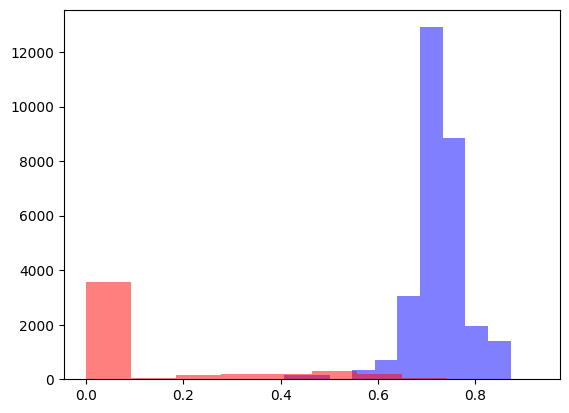

In [21]:
plt.hist(X_nyu[:, 400], color='blue', alpha=0.5)
plt.hist(transformed_X_um1_test[:, 0], color='red', alpha=0.5)
plt.show()

In [22]:
transformed_X_um1_test

array([[0.52042062, 0.52042062, 0.52042062, ..., 0.52042062, 0.52042062,
        0.52042062],
       [0.54404847, 0.54404847, 0.54404847, ..., 0.54404847, 0.54404847,
        0.54404847],
       [0.54307128, 0.54307128, 0.54307128, ..., 0.54307128, 0.54307128,
        0.54307128],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [23]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model = SVC(kernel="rbf", C=1.0, class_weight='balanced', random_state=42, verbose=True)
model.fit(X=X_nyu, y=y_nyu)

[LibSVM]......
*
optimization finished, #iter = 6989
obj = -2785.391215, rho = -1.739338
nSV = 5598, nBSV = 3940
Total nSV = 5598


SVC(class_weight='balanced', random_state=42, verbose=True)

(1754, 263, 2212, 491)

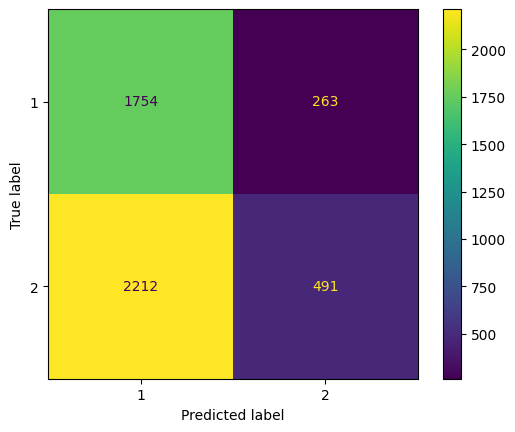

In [24]:
test_predictions = model.predict(X_um1_test)
cm = confusion_matrix(y_um1_test, test_predictions, labels=model.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
display.plot()
tn, fp, fn, tp = cm.ravel()
tn, fp, fn, tp

(2017, 0, 2703, 0)

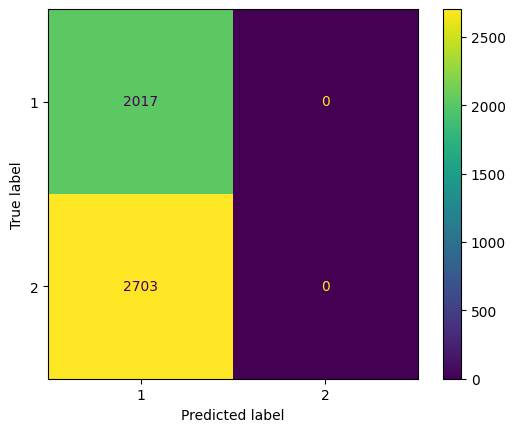

In [25]:
test_predictions = model.predict(transformed_X_um1_test)
cm = confusion_matrix(y_um1_test, test_predictions, labels=model.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
display.plot()
tn, fp, fn, tp = cm.ravel()
tn, fp, fn, tp